# CS445: Computational Photography
## Programming Project 4: Image-Based Lighting


## Recovering HDR Radiance Maps 

Load libraries and data

In [1]:
# jupyter extension that allows reloading functions from imports without clearing kernel :D
%load_ext autoreload
%autoreload 2

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# System imports
import os
from os import path
import math

# Third-Party Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

%matplotlib inline
from random import random
import time
import scipy
import scipy.sparse.linalg

from IPython.display import HTML
from IPython.display import Video
import shutil

# modify to where you store your project data including utils
datadir = "C:/Users/chaob/Desktop/445/finalproject/fp/FinalProject" 

utilfn = datadir + "utils"
# !cp -r "$utilfn" .
samplesfn = datadir + "samples"
# !cp -r "$samplesfn" .

# can change this to your output directory of choice
# !mkdir "images"
# !mkdir "images/outputs"

# import starter code
import utils
from utils.io import read_image, write_image, read_hdr_image, write_hdr_image
from utils.display import display_images_linear_rescale, rescale_images_linear
from utils.hdr_helpers import gsolve
from utils.hdr_helpers import get_equirectangular_image
from utils.bilateral_filter import bilateral_filter
from utils.bilateral_filter import bilateral_filter
import utils.points 



### Reading Videos



In [4]:
def import_video(video_path):

    # Create a directory to store the extracted frames
    output_folder = 'frames'+ '/' + vname
    
    # Check if the directory exists
    if os.path.exists(output_folder):
        # If it exists, remove the directory and its contents
        shutil.rmtree(output_folder)
    os.makedirs(output_folder, exist_ok=True)

    # Open the video file
    video = cv2.VideoCapture(video_path)

    # Get the video properties
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(video.get(cv2.CAP_PROP_FPS))
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    # Initialize variables
    frame_count = 0
    frames = []

    # Read frames from the video
    while True:
        ret, frame = video.read()
        if not ret:
            break

        # Save the frame as an image in the output folder
        frame_path = os.path.join(output_folder, f"frame_{frame_count:04d}.jpg")
        cv2.imwrite(frame_path, frame)

        # Append the frame to the list
        frames.append(frame)

        frame_count += 1

    # Release the video object
    video.release()

    print(f"Total frames: {total_frames}")
    print(f"Frames extracted: {frame_count}")
    print(f"Frames saved in the folder: {output_folder}")

    return frames, width, height, fps


In [42]:
imdir = 'samples'
vname = 'cat1'

# Specify the path to the video file
video_path = imdir + '/' + vname +'.mp4'

# Import the video and get the frames and video properties
frames, width, height, fps = import_video(video_path)

Total frames: 144
Frames extracted: 144
Frames saved in the folder: frames/cat1


In [6]:
# Display the video in the notebook
video = Video(video_path)
print(video_path)
display(video)

samples/cat1.mp4


In [7]:
# First frame is background, or can be frames[0]
background_image_file = 'frames'+ '/' + vname + '/' +'frame_0000.jpg'
background_image = read_image(background_image_file)

# background_image_file = imdir + '/' + 'empty.jpg'
# background_image = read_image(background_image_file)

### Background removal

Compute the HDR image as average of irradiance estimates from LDR images

In [8]:
def background_subtraction_p(frames, width, height, fps, vname):
    # Create directories to store the output frames and video
    output_folder_bs = "background_removed_frames_p" + '/' + vname
    
    # Check if the directory exists
    if os.path.exists(output_folder_bs):
        # If it exists, remove the directory and its contents
        shutil.rmtree(output_folder_bs)
    os.makedirs(output_folder_bs, exist_ok=True)
    
    # Read the first frame as the background image
    background = cv2.cvtColor(frames[0], cv2.COLOR_BGR2GRAY)
    
    # Apply blurring to the background frame
    blurred_background = cv2.GaussianBlur(background, (15, 15), 0)
    
    # Initialize variables
    processed_frames = []
    
    # Create a kernel for morphological operations
    kernel = np.ones((20, 20), np.uint8)
    
    # Process frames for background subtraction
    for i, frame in enumerate(frames):
        # Convert the frame to grayscale
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Apply blurring to the grayscale frame
        blurred_frame = cv2.GaussianBlur(gray_frame, (15, 15), 0)
        
        # Perform background subtraction
        diff = cv2.absdiff(blurred_background, blurred_frame)
        
        # Apply thresholding
        threshold = 60
        _, thresh = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY)
                
        # Save the thresholded frame as an image in the output folder
        frame_path_bs = os.path.join(output_folder_bs, f"frame_{i:04d}.jpg")
        cv2.imwrite(frame_path_bs, thresh)
        
        # Append the processed frame to the list
        processed_frames.append(thresh)
    
    print(f"Background subtraction completed.")
    print(f"Output frames saved in the folder: {output_folder_bs}")
    
    return processed_frames, output_folder_bs

In [9]:
# Perform background subtraction on the frames and get the processed frames
processed_frames_p, output_folder_bs_p = background_subtraction_p(frames, width, height, fps, vname)

Background subtraction completed.
Output frames saved in the folder: background_removed_frames_p/cat1


In [10]:
%%capture
!ffmpeg -framerate 30 -i "{output_folder_bs_p}/frame_%04d.jpg" -c:v libx264 -pix_fmt yuv420p "{output_folder_bs_p}/bs_video.mp4"

In [11]:
def background_subtraction_o(frames, width, height, fps, vname):
    # Create directories to store the output frames and video
    output_folder_bs = "background_removed_frames_o" + '/' + vname
    
    # Check if the directory exists
    if os.path.exists(output_folder_bs):
        # If it exists, remove the directory and its contents
        shutil.rmtree(output_folder_bs)
    os.makedirs(output_folder_bs, exist_ok=True)
    
    # Read the first frame as the background image
    background = cv2.cvtColor(frames[0], cv2.COLOR_BGR2GRAY)
    
    # Apply blurring to the background frame
    blurred_background = cv2.GaussianBlur(background, (15, 15), 0)
    
    # Initialize variables
    processed_frames = []
    
    # Create a kernel for morphological operations
    kernel = np.ones((5, 5), np.uint8)
    
    # Process frames for background subtraction
    for i, frame in enumerate(frames):
        # Convert the frame to grayscale
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Apply blurring to the grayscale frame
        blurred_frame = cv2.GaussianBlur(gray_frame, (15, 15), 0)
        
        # Perform background subtraction
        diff = cv2.absdiff(blurred_background, blurred_frame)
        
        # Apply thresholding
        threshold = 20
        _, thresh = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY)
        
        # Apply erosion
        eroded = cv2.erode(thresh, kernel, iterations=2)
        
        # # Apply dilation
        dilated = cv2.dilate(eroded, kernel, iterations=2)
        
        # Save the thresholded frame as an image in the output folder
        frame_path_bs = os.path.join(output_folder_bs, f"frame_{i:04d}.jpg")
        cv2.imwrite(frame_path_bs, dilated)
        
        # Append the processed frame to the list
        processed_frames.append(thresh)
    
    print(f"Background subtraction completed.")
    print(f"Output frames saved in the folder: {output_folder_bs}")
    
    return processed_frames, output_folder_bs

In [12]:
# Perform background subtraction on the frames and get the processed frames
processed_frames_o, output_folder_bs_o = background_subtraction_o(frames, width, height, fps, vname)

Background subtraction completed.
Output frames saved in the folder: background_removed_frames_o/cat1


In [13]:
%%capture
!ffmpeg -framerate 30 -i "{output_folder_bs_o}/frame_%04d.jpg" -c:v libx264 -pix_fmt yuv420p "{output_folder_bs_o}/bs_video.mp4"

In [14]:
#会占用导致无法更改，最后展示用
# # Display the video in the notebook
# v="background_removed_frames/cat1/bs_video.mp4"
# video = Video(v)
# display(video)

In [72]:
def background_subtraction_improve(frames, width, height, fps, vname, kernel,GaussianBlurframe,i1,i2):
    # Create directories to store the output frames and video
    output_folder_bs = "background_removed_frames_improve" + '/' + vname
    
    # Check if the directory exists
    if os.path.exists(output_folder_bs):
        # If it exists, remove the directory and its contents
        shutil.rmtree(output_folder_bs)
    os.makedirs(output_folder_bs, exist_ok=True)
        
    # Initialize variables
    processed_frames = []
    
#     # Create a kernel for morphological operations
#     kernel = np.ones((5, 5), np.uint8)
    
    # Create a GMM-based background subtractor
    background_subtractor = cv2.createBackgroundSubtractorKNN(detectShadows=True)
    
    # Define the number of initial frames to skip or use for training
    num_initial_frames = 5

    # Train the background subtractor on initial frames
    for i in range(num_initial_frames):
        frame = frames[i]
        blurred_frame = cv2.GaussianBlur(frame, (GaussianBlurframe, GaussianBlurframe), 0)
        _ = background_subtractor.apply(blurred_frame)

    # Process frames for background subtraction
    for i, frame in enumerate(frames):
        
        blurred_frame = cv2.GaussianBlur(frame, (GaussianBlurframe, GaussianBlurframe), 0)
        # Apply background subtraction
        mask = background_subtractor.apply(blurred_frame)

        # Apply thresholding to the mask
        _, thresh = cv2.threshold(mask, 250, 255, cv2.THRESH_BINARY)
    
       
        # Apply erosion
        eroded = cv2.erode(thresh, kernel, iterations=i1)
        
        # # Apply dilation
        dilated = cv2.dilate(eroded, kernel, iterations=i2)
        
        # Save the thresholded frame as an image in the output folder
        frame_path_bs = os.path.join(output_folder_bs, f"frame_{i:04d}.jpg")
        cv2.imwrite(frame_path_bs, dilated)
        
        # Append the processed frame to the list
        processed_frames.append(thresh)
    
    print(f"Background subtraction completed.")
    print(f"Output frames saved in the folder: {output_folder_bs}")
    
    return processed_frames, output_folder_bs

In [44]:
# Create a kernel for morphological operations
kernel = np.ones((5, 5), np.uint8)

GaussianBlurframe=15

#erode and dilate iteration
i1=1
i2=3

# Perform background subtraction on the frames and get the processed frames
processed_frames_improve, output_folder_bs_improve = background_subtraction_improve(frames, width, height, fps, vname, kernel, GaussianBlurframe, i1,i2)

Background subtraction completed.
Output frames saved in the folder: background_removed_frames_improve/cat1


In [45]:
%%capture
!ffmpeg -framerate 30 -i "{output_folder_bs_improve}/frame_%04d.jpg" -c:v libx264 -pix_fmt yuv420p "{output_folder_bs_improve}/bs_video.mp4"

### Remove not interested objects

In [46]:
def filter_white_regions(image_path, thres):
    # Read the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Find contours in the binary image
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Check if any contours were found
    if len(contours) > 0:
        # Find the area of the largest contour
        largest_area = max(cv2.contourArea(contour) for contour in contours)
        
        # Set the area threshold to be the area of the largest contour minus 200
        area_threshold = largest_area - 0.05*largest_area
        
        # Create a mask to store the filtered white regions
        mask = np.zeros_like(image)
        
        # Iterate over each contour
        for contour in contours:
            # Calculate the area of the contour
            area = cv2.contourArea(contour)
            
            # If the area is greater than or equal to the threshold, draw the contour on the mask
            if area > thres and area >= area_threshold:
                cv2.drawContours(mask, [contour], 0, 255, -1)
        
        # Apply the mask to the original image
        result = cv2.bitwise_and(image, image, mask=mask)
    else:
        # If no contours were found, return the original image
        result = image
    
    return result

In [47]:

# Specify the folder path containing the black and white images
folder_path = output_folder_bs_improve

# Create a new folder to store the processed images
out_folder = "obj_frames_improve" + '/' + vname
# Check if the directory exists
if os.path.exists(out_folder):
    # If it exists, remove the directory and its contents
    shutil.rmtree(out_folder)
os.makedirs(out_folder, exist_ok=True)

thres=2000

# Iterate over each image file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg") :  # Adjust the file extensions as needed
        image_path = os.path.join(folder_path, filename)
        
        # Process the image to keep the white regions with areas greater than or equal to the threshold
        processed_image = filter_white_regions(image_path, thres)
        
        # Save the processed image to the output folder
        output_path = os.path.join(out_folder, filename)
        cv2.imwrite(output_path, processed_image)

In [48]:
%%capture
!ffmpeg -framerate 30 -i "{out_folder}/frame_%04d.jpg" -c:v libx264 -pix_fmt yuv420p "{out_folder}/obj_video.mp4"

### putdown marker

In [49]:
def find_connected_components(mask, max_distance, min_area_threshold):
    mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    ret, labels = cv2.connectedComponents(mask)
    unique_labels, counts = np.unique(labels, return_counts=True)

    label_map = {label: label for label in unique_labels if label != 0}
    rectangle_map = {}

    for label, count in zip(unique_labels, counts):
        if label == 0:  # Background
            continue

        if count < min_area_threshold:
            labels[labels == label] = 0  # Set labels with small counts to 0 (black)
            continue

        component_mask = (labels == label).astype(np.uint8)
        contours, _ = cv2.findContours(component_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for i in range(len(contours)):
            x1, y1, w1, h1 = cv2.boundingRect(contours[i])
            rect1 = np.array([[x1, y1], [x1 + w1, y1], [x1 + w1, y1 + h1], [x1, y1 + h1]], dtype=np.int32)

            for j in range(i+1, len(contours)):
                x2, y2, w2, h2 = cv2.boundingRect(contours[j])
                rect2 = np.array([[x2, y2], [x2 + w2, y2], [x2 + w2, y2 + h2], [x2, y2 + h2]], dtype=np.int32)

                distances = [cv2.pointPolygonTest(rect1, tuple(point), True) for point in rect2]
                if any(abs(dist) <= max_distance for dist in distances):
                    component_mask = cv2.drawContours(component_mask, contours, j, 1, -1)

        labels[component_mask == 1] = label
        rectangle_map[label] = rect1

    for label1, rect1 in rectangle_map.items():
        for label2, rect2 in rectangle_map.items():
            if label1 >= label2:
                continue

            if len(rect2)>0:
#                 print(rect1,"and",rect2)
                distances = [cv2.pointPolygonTest(rect1, tuple([int(round(point[0]) ), int(round( point[1] )) ]), True) for point in rect2]
                if any(abs(dist) <= max_distance for dist in distances):
                    min_label = min(label_map[label1], label_map[label2])
                    max_label = max(label_map[label1], label_map[label2])
                    label_map[max_label] = min_label

    new_labels = np.zeros_like(labels)
    for old_label, new_label in label_map.items():
        new_labels[labels == old_label] = label_map[new_label]

    return new_labels

In [50]:
def draw_bounding_boxes(image, labels):
    # Apply thresholding
#     thresholded_image = cv2.threshold(labels, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    
    unique_labels = np.unique(labels)
#     print(unique_labels)
    
    for label in unique_labels:
        if label == 0:  # Background
            continue
        
        component_mask = (labels == label).astype(np.uint8)
        
        # Find the indices of non-zero pixels in the component mask
        non_zero_indices = np.nonzero(component_mask)
        
        if len(non_zero_indices[0]) > 0:
            # Find the minimum and maximum values of x and y coordinates
            y_min = np.min(non_zero_indices[0])
            y_max = np.max(non_zero_indices[0])
            x_min = np.min(non_zero_indices[1])
            x_max = np.max(non_zero_indices[1])
            
            # Draw the bounding box rectangle
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.putText(image, "object", (x_min, y_min-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    return image

In [51]:
# Specify the folder paths
original_frames_folder = 'frames/cat1'
white_frames_folder = 'obj_frames_improve/cat1'
marked_folder = 'marked/cat1'

# Check if the directory exists
if os.path.exists(marked_folder):
    # If it exists, remove the directory and its contents
    shutil.rmtree(marked_folder)
# Create the output folder if it doesn't exist
os.makedirs(marked_folder, exist_ok=True)

# Set the maximum distance threshold for connecting components
max_distance = 100
min_area_threshold=2000

# Get the list of frame filenames in the original frames folder
original_frame_filenames = sorted(os.listdir(original_frames_folder))

# Iterate through each frame filename
for filename in original_frame_filenames:
    if filename.endswith(".jpg") or filename.endswith(".png"):
        mask_path = os.path.join(white_frames_folder, filename)
        original_path = os.path.join(original_frames_folder, filename)
        output_path = os.path.join(marked_folder, filename)
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        original = cv2.imread(original_path)
        
        labels = find_connected_components(mask, max_distance, min_area_threshold)
        result = draw_bounding_boxes(original, labels)
        
        cv2.imwrite(output_path, result)

In [52]:
%%capture
!ffmpeg -framerate 30 -i "{marked_folder}/frame_%04d.jpg" -c:v libx264 -pix_fmt yuv420p "{marked_folder}/marked_video.mp4"

### second example

In [62]:
imdir = 'samples'
vname = 'cat2'

# Specify the path to the video file
video_path = imdir + '/' + vname +'.mp4'

# Import the video and get the frames and video properties
frames, width, height, fps = import_video(video_path)

Total frames: 129
Frames extracted: 129
Frames saved in the folder: frames/cat2


In [63]:
# Display the video in the notebook
video = Video(video_path)
print(video_path)
display(video)

samples/cat2.mp4


In [64]:
# First frame is background, or can be frames[0]
background_image_file = 'frames'+ '/' + vname + '/' +'frame_0000.jpg'
background_image = read_image(background_image_file)

# background_image_file = imdir + '/' + 'empty.jpg'
# background_image = read_image(background_image_file)

In [90]:
# Create a kernel for morphological operations
kernel = np.ones((20, 20), np.uint8)

GaussianBlurframe=25

i1=2
i2=2

# Perform background subtraction on the frames and get the processed frames
processed_frames_improve, output_folder_bs_improve = background_subtraction_improve(frames, width, height, fps, vname, kernel, GaussianBlurframe, i1,i2)

Background subtraction completed.
Output frames saved in the folder: background_removed_frames_improve/cat2


In [91]:
%%capture
!ffmpeg -framerate 30 -i "{output_folder_bs_improve}/frame_%04d.jpg" -c:v libx264 -pix_fmt yuv420p "{output_folder_bs_improve}/bs_video.mp4"

In [92]:

# Specify the folder path containing the black and white images
folder_path = output_folder_bs_improve

# Create a new folder to store the processed images
out_folder = "obj_frames_improve" + '/' + vname
# Check if the directory exists
if os.path.exists(out_folder):
    # If it exists, remove the directory and its contents
    shutil.rmtree(out_folder)
os.makedirs(out_folder, exist_ok=True)

thres=2000

# Iterate over each image file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg") :  # Adjust the file extensions as needed
        image_path = os.path.join(folder_path, filename)
        
        # Process the image to keep the white regions with areas greater than or equal to the threshold
        processed_image = filter_white_regions(image_path, thres)
        
        # Save the processed image to the output folder
        output_path = os.path.join(out_folder, filename)
        cv2.imwrite(output_path, processed_image)

In [93]:
%%capture
!ffmpeg -framerate 30 -i "{out_folder}/frame_%04d.jpg" -c:v libx264 -pix_fmt yuv420p "{out_folder}/obj_video.mp4"

In [94]:
# Specify the folder paths
original_frames_folder = 'frames/cat2'
white_frames_folder = 'obj_frames_improve/cat2'
marked_folder = 'marked/cat2'

# Check if the directory exists
if os.path.exists(marked_folder):
    # If it exists, remove the directory and its contents
    shutil.rmtree(marked_folder)
# Create the output folder if it doesn't exist
os.makedirs(marked_folder, exist_ok=True)

# Set the maximum distance threshold for connecting components
max_distance = 100
min_area_threshold=2000

# Get the list of frame filenames in the original frames folder
original_frame_filenames = sorted(os.listdir(original_frames_folder))

# Iterate through each frame filename
for filename in original_frame_filenames:
    if filename.endswith(".jpg") or filename.endswith(".png"):
        mask_path = os.path.join(white_frames_folder, filename)
        original_path = os.path.join(original_frames_folder, filename)
        output_path = os.path.join(marked_folder, filename)
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        original = cv2.imread(original_path)
        
        labels = find_connected_components(mask, max_distance, min_area_threshold)
        result = draw_bounding_boxes(original, labels)
        
        cv2.imwrite(output_path, result)

In [95]:
%%capture
!ffmpeg -framerate 30 -i "{marked_folder}/frame_%04d.jpg" -c:v libx264 -pix_fmt yuv420p "{marked_folder}/marked_video.mp4"

## check eating

In [25]:
imdir = 'samples'
vname = 'catwithbowl'

# Specify the path to the video file
video_path = imdir + '/' + vname +'.mp4'

# Import the video and get the frames and video properties
frames, width, height, fps = import_video(video_path)

Total frames: 674
Frames extracted: 674
Frames saved in the folder: frames/catwithbowl


In [26]:
# Display the video in the notebook
video = Video(video_path)
print(video_path)
display(video)

samples/catwithbowl.mp4


In [27]:
# First frame is background, or can be frames[0]
# background_image_file = 'frames'+ '/' + vname + '/' +'frame_0000.jpg'
# background_image = read_image(background_image_file)

# background_image_file = imdir + '/' + 'empty.jpg'
# background_image = read_image(background_image_file)

In [28]:
#color
im1_file_c = 'frames/catwithbowl/frame_0000.jpg'

im1_c = np.float32(cv2.imread(im1_file_c) / 255.0)

#Convert BGR to RGB
im1_c = cv2.cvtColor(im1_c, cv2.COLOR_BGR2RGB)

In [29]:
def get_bounding_box(xs, ys):
    x1, y1 = min(xs), min(ys)
    x2, y2 = max(xs), max(ys)
    return [int(y1), int(y2), int(x1), int(x2)]

In [30]:
def get_draw_mask(ys, xs, img):
    
    # Get the bounding box coordinates
    y1, y2, x1, x2 = get_bounding_box(xs, ys)
    
    # Draw the bounding box on the image
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    img_with_bbox = img.copy()
    rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
    ax.imshow(img_with_bbox, cmap='gray')
    ax.add_patch(rect)
    ax.set_title('Image with Bounding Box')
    ax.axis('off')
    
    plt.show()
    
    return [y1, y2, x1, x2]


If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


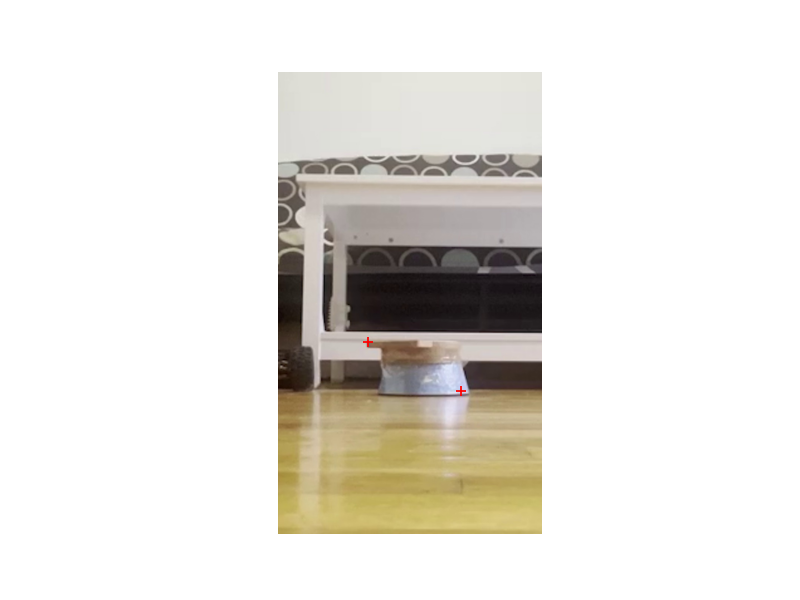

In [31]:
import matplotlib.pyplot as plt
%matplotlib notebook
pts = utils.points.specify_mask(im1_c)


<Figure size 640x480 with 0 Axes>

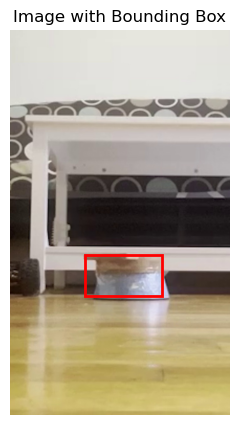

In [33]:
xs, ys = pts[0], pts[1]
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
bowlcoord = get_draw_mask(ys, xs, im1_c)

In [34]:
# Create a kernel for morphological operations
kernel = np.ones((9, 9), np.uint8)

GaussianBlurframe=3

i1=1
i2=3

# Perform background subtraction on the frames and get the processed frames
processed_frames_improve, output_folder_bs_improve = background_subtraction_improve(frames, width, height, fps, vname, kernel,GaussianBlurframe, i1, i2)

Background subtraction completed.
Output frames saved in the folder: background_removed_frames_improve/catwithbowl


In [35]:
%%capture
!ffmpeg -framerate 30 -i "{output_folder_bs_improve}/frame_%04d.jpg" -c:v libx264 -pix_fmt yuv420p "{output_folder_bs_improve}/bs_video.mp4"

In [36]:

# Specify the folder path containing the black and white images
folder_path = output_folder_bs_improve

# Create a new folder to store the processed images
out_folder = "obj_frames_improve" + '/' + vname
# Check if the directory exists
if os.path.exists(out_folder):
    # If it exists, remove the directory and its contents
    shutil.rmtree(out_folder)
os.makedirs(out_folder, exist_ok=True)

thres=100

# Iterate over each image file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg") :  # Adjust the file extensions as needed
        image_path = os.path.join(folder_path, filename)
        
        # Process the image to keep the white regions with areas greater than or equal to the threshold
        processed_image = filter_white_regions(image_path, thres)
        
        # Save the processed image to the output folder
        output_path = os.path.join(out_folder, filename)
        cv2.imwrite(output_path, processed_image)

In [37]:
%%capture
!ffmpeg -framerate 30 -i "{out_folder}/frame_%04d.jpg" -c:v libx264 -pix_fmt yuv420p "{out_folder}/obj_video.mp4"

In [38]:
# Specify the folder paths
original_frames_folder = 'frames/catwithbowl'
white_frames_folder = 'obj_frames_improve/catwithbowl'
marked_folder = 'marked/catwithbowl'

# Check if the directory exists
if os.path.exists(marked_folder):
    # If it exists, remove the directory and its contents
    shutil.rmtree(marked_folder)
# Create the output folder if it doesn't exist
os.makedirs(marked_folder, exist_ok=True)

# Set the maximum distance threshold for connecting components
max_distance = 50
min_area_threshold=100

# Get the list of frame filenames in the original frames folder
original_frame_filenames = sorted(os.listdir(original_frames_folder))

# Iterate through each frame filename
for filename in original_frame_filenames:
    if filename.endswith(".jpg") or filename.endswith(".png"):
        mask_path = os.path.join(white_frames_folder, filename)
        original_path = os.path.join(original_frames_folder, filename)
        output_path = os.path.join(marked_folder, filename)
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        original = cv2.imread(original_path)
        
        labels = find_connected_components(mask, max_distance, min_area_threshold)
        result = draw_bounding_boxes(original, labels)
        
        cv2.imwrite(output_path, result)

In [39]:
%%capture
!ffmpeg -framerate 30 -i "{marked_folder}/frame_%04d.jpg" -c:v libx264 -pix_fmt yuv420p "{marked_folder}/marked_video.mp4"

In [40]:
# Specify the folder paths
# white_frames_folder
eat_folder = 'checkeat/catwithbowl'

# Check if the directory exists
if os.path.exists(eat_folder):
    # If it exists, remove the directory and its contents
    shutil.rmtree(eat_folder)

# Create the output folder if it doesn't exist
os.makedirs(eat_folder, exist_ok=True)

# Set the maximum distance threshold for connecting components
margin = 50

# Get the list of frame filenames in the original frames folder
mask_frame_filenames = sorted(os.listdir(white_frames_folder))

# Iterate through each frame filename
for filename in mask_frame_filenames:
    if filename.endswith(".jpg") or filename.endswith(".png"):
        mask_path = os.path.join(white_frames_folder, filename)
        output_path = os.path.join(eat_folder, filename)
        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        frame = cv2.imread(os.path.join(original_frames_folder, filename))
        
        # Check if the white area overlaps or contains the bowlcoord area
        y1, y2, x1, x2 = bowlcoord
        roi = mask[y1-margin:y2, x1:x2]
#         print(mask.shape)
#         print(bowlcoord, roi)
        
        if cv2.countNonZero(roi) > 0:
            # Draw a bounding box around the bowlcoord area
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            # Add the "eating" tag to the frame
            cv2.putText(frame, "eating", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        
        cv2.imwrite(output_path, frame)

In [41]:
%%capture
!ffmpeg -framerate 30 -i "{eat_folder}/frame_%04d.jpg" -c:v libx264 -pix_fmt yuv420p "{eat_folder}/eat_video.mp4"